# Final Project
Quinn Frank <br>
November 23, 2020

In [127]:
# Import NLTK to load training data
import re
import nltk
nltk.download("tagsets")
nltk.download("brown")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
from nltk import sent_tokenize, word_tokenize, pos_tag

# Import my modules
from hmm import HMM
from blstm import *
from tagging_results import TaggingResults

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# CAN LOAD PRE-TRAINED MODELS HERE

def enpickle(obj, file):
    import pickle
    with open(file, 'wb') as out_file:
        pickle.dump(obj, out_file)

def unpickle(file):
    import pickle
    with open(file, 'rb') as in_file:
        pickle_dict = pickle.load(in_file, encoding='bytes')
    return pickle_dict

#hmm = unpickle("models/hmm")
#summ = unpickle("models/blstm_train_summ")
#net = torch.load("models/blstm")

## Step 2: Generative Model

In [34]:
train_size, test_size = 30000, 5000   # actual test set may be < test_size
train = nltk.corpus.brown.tagged_sents(tagset="universal")[:train_size]
test = nltk.corpus.brown.tagged_sents(tagset="universal")[train_size:train_size+test_size]

In [45]:
hmm = HMM()
%time hmm.fit(train)
%time test_sents, y_true, y_predict = hmm.split_predict(test)    # time this

Wall time: 5min 51s
Wall time: 11.8 s


In [46]:
# Calculate accuracy of HMM on both datasets
hmm_train = TaggingResults(hmm, train, hmm.vocab, hmm.tagset)
hmm_test = TaggingResults(hmm, test, hmm.vocab, hmm.tagset)

hmm_train.get_accuracy()
hmm_test.get_accuracy()


Accuracy
--------
total               0.9750
in vocab            0.9750
out of vocab           NaN
ambiguous tokens    0.9491
dtype: float64

Accuracy
--------
total               0.9346
in vocab            0.9719
out of vocab        0.2673
ambiguous tokens    0.8974
dtype: float64


## Step 3: Discriminative Model

In [35]:
untagged_train = nltk.corpus.brown.sents()[:train_size]
%time embedder = train_fasttext(untagged_train)

# Also store the vocabulary for later
net_vocab = pd.Index(sorted(set(sum(untagged_train, []))))

Wall time: 17.7 s


In [42]:
train_set = POSDataset(train, embedder, hmm.tagset)
test_set = POSDataset(test, embedder, hmm.tagset)

# Network is loaded onto a GPU by default
# (to run on cpu, remove .cuda() and set use_cuda below to False)
net = BLSTM(100, len(hmm.tagset), 128, 2, 0.2)

In [43]:
net.cuda()
%time summ = train_BLSTM(net, train_set, test_set, \
                         num_epochs=40, batch_size=16, use_cuda=True, \
                         print_every=1, train_summ=None, \
                         opt_params={'lr': 0.1, 'momentum': 0.8})

- EPOCH 1:
  train loss = 0.5588613748550415
  accuracy   = 0.9066 (train) / 0.9106 (test)
----------------------------
- EPOCH 2:
  train loss = 0.4956792891025543
  accuracy   = 0.9256 (train) / 0.9258 (test)
----------------------------
- EPOCH 3:
  train loss = 0.4926051199436188
  accuracy   = 0.9336 (train) / 0.9331 (test)
----------------------------
- EPOCH 4:
  train loss = 0.47339779138565063
  accuracy   = 0.9387 (train) / 0.9374 (test)
----------------------------
- EPOCH 5:
  train loss = 0.48047271370887756
  accuracy   = 0.9424 (train) / 0.9394 (test)
----------------------------
- EPOCH 6:
  train loss = 0.4446640610694885
  accuracy   = 0.9454 (train) / 0.9427 (test)
----------------------------
- EPOCH 7:
  train loss = 0.4515708088874817
  accuracy   = 0.948 (train) / 0.9446 (test)
----------------------------
- EPOCH 8:
  train loss = 0.46215829253196716
  accuracy   = 0.95 (train) / 0.9466 (test)
----------------------------
- EPOCH 9:
  train loss = 0.433892637491

Wall time: 5.02 s


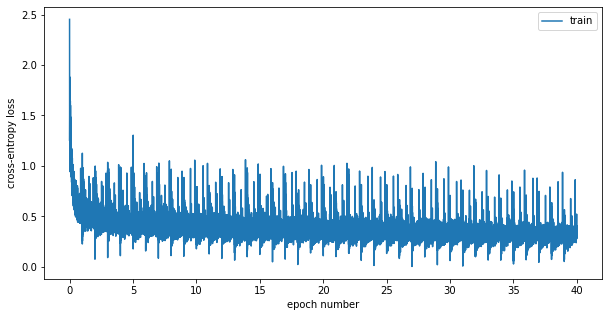

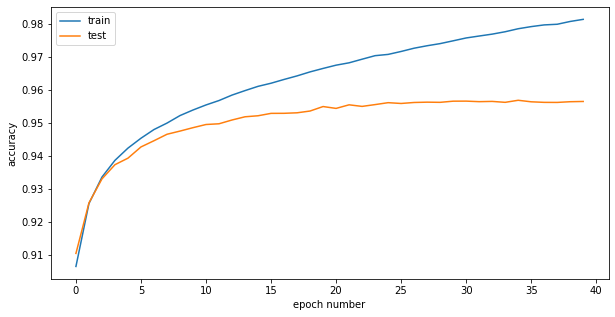


Accuracy
--------
total               0.9793
in vocab            0.9793
out of vocab           NaN
ambiguous tokens    0.9816
dtype: float64

Accuracy
--------
total               0.9543
in vocab            0.9622
out of vocab        0.8269
ambiguous tokens    0.9334
dtype: float64


In [44]:
net.cpu()
%time test_sents, y_true, y_predict = net.split_predict(test_set)   # time this
plot_train_summ(summ)

# Calculate accuracy of BiLSTM on both datasets
net_train = TaggingResults(net, train, net_vocab, hmm.tagset, embedder)
net_test = TaggingResults(net, test, net_vocab, hmm.tagset, embedder)

net_train.get_accuracy()
net_test.get_accuracy()

In [47]:
# STORE MODELS HERE ONCE TRAINED

#enpickle(hmm, "models/hmm")
#enpickle(summ, "models/blstm_train_summ")
#torch.save(net, "models/blstm")

# Step 4: Application to Artificial Data

In [97]:
# Generate an artificial tagged dataset to test on
np.random.seed(0)
%time artificial = hmm.generate(5000)

Wall time: 1min 37s


In [98]:
# Calculate the accuracy on the artifical dataset
hmm_art = TaggingResults(hmm, artificial, hmm.vocab, hmm.tagset)
net_art = TaggingResults(net, artificial, net_vocab, hmm.tagset, embedder)

hmm_art.get_accuracy()
net_art.get_accuracy()


Accuracy
--------
total               0.9779
in vocab            0.9779
out of vocab           NaN
ambiguous tokens    0.9267
dtype: float64

Accuracy
--------
total               0.8800
in vocab            0.8865
out of vocab        0.7593
ambiguous tokens    0.8202
dtype: float64


In [150]:
# Confusion matrices, conditioned on true label
print("\nConfusion matrix for HMM on generated data:")
print("- entry i,j = Pr(y_predict = j | y_true = i)\n")
pd.DataFrame(confusion_matrix(hmm_art.res.y_true, hmm_art.res.y_predict, normalize='true'),
             index=hmm.tagset, columns=hmm.tagset).round(2)


Confusion matrix for HMM on generated data:
- entry i,j = Pr(y_predict = j | y_true = i)



,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
ADJ,0.0,0.97,0.00,0.01,0.00,0.00,0.02,0.0,0.00,0.00,0.00,0.00
ADP,0.0,0.00,0.98,0.00,0.00,0.00,0.00,0.0,0.00,0.01,0.00,0.00
ADV,0.0,0.02,0.02,0.94,0.00,0.00,0.00,0.0,0.00,0.01,0.00,0.00
CONJ,0.0,0.00,0.00,0.00,1.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
DET,0.0,0.00,0.00,0.00,0.00,0.99,0.00,0.0,0.00,0.00,0.00,0.00
NOUN,0.0,0.01,0.00,0.00,0.00,0.00,0.98,0.0,0.00,0.00,0.01,0.00
NUM,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.00
PRON,0.0,0.00,0.01,0.00,0.00,0.00,0.00,0.0,0.99,0.00,0.00,0.00
PRT,0.0,0.00,0.13,0.01,0.00,0.00,0.00,0.0,0.00,0.85,0.00,0.00


In [147]:
print("\nConfusion matrix for BiLSTM on generated data:\n")
pd.DataFrame(confusion_matrix(net_art.res.y_true, net_art.res.y_predict, normalize='true'),
             index=hmm.tagset, columns=hmm.tagset).round(2)


Confusion matrix for BiLSTM on generated data:



,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ADJ,0.0,0.69,0.00,0.03,0.00,0.00,0.21,0.00,0.00,0.00,0.06,0.00
ADP,0.0,0.00,0.94,0.01,0.00,0.01,0.00,0.00,0.01,0.03,0.01,0.00
ADV,0.0,0.06,0.04,0.81,0.00,0.01,0.06,0.00,0.00,0.01,0.02,0.00
CONJ,0.0,0.00,0.00,0.00,0.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00
DET,0.0,0.00,0.00,0.00,0.00,0.99,0.00,0.00,0.00,0.00,0.00,0.00
NOUN,0.0,0.06,0.00,0.01,0.00,0.00,0.86,0.01,0.00,0.00,0.05,0.00
NUM,0.0,0.01,0.00,0.00,0.00,0.00,0.16,0.81,0.00,0.00,0.01,0.00
PRON,0.0,0.00,0.01,0.00,0.00,0.03,0.06,0.02,0.87,0.00,0.00,0.00
PRT,0.0,0.01,0.29,0.06,0.00,0.00,0.01,0.00,0.00,0.62,0.00,0.00


In [179]:
hmm_art.get_sent(17)

             true predict correct? oov? ambiguous?
token                                             
no            DET     DET        ✓               *
force        NOUN    NOUN        ✓               *
sociologist  NOUN    NOUN        ✓                
``              .       .        ✓                
fourteenth    ADJ     ADJ        ✓                
in            ADP     ADP        ✓               *
the           DET     DET        ✓                
things       NOUN    NOUN        ✓                
.               .       .        ✓                


In [178]:
net_art.get_sent(17)

             true predict correct? oov? ambiguous?
token                                             
no            DET     DET        ✓               *
force        NOUN     ADJ                        *
sociologist  NOUN    NOUN        ✓                
``              .       .        ✓                
fourteenth    ADJ     NUM                         
in            ADP     ADP        ✓               *
the           DET     DET        ✓                
things       NOUN    NOUN        ✓                
.               .       .        ✓                


# Step 5: Application to Real Data

### Trump Tweets

In [103]:
def convert_tweet(tweet):
    """Given a string (which may contain multiple sentences),
       splits into sentences, tokenizes each, and automatically tags with NLTK.
       Also removes hyperlinks and @ references."""
    
    to_remove = r"http\S*\b|@|#"
    tweet = re.sub(to_remove, " ", tweet)
    tweet_sents = sent_tokenize(tweet)
    tag = lambda sent: pos_tag(word_tokenize(sent), tagset='universal')
    tweet_data = list(map(tag, tweet_sents))
    return tweet_data

# Compile a compatible training set from the downloaded tweets
all_months = [pd.read_json(f"data/trump{i}.json", encoding="utf8") for i in range(8, 11)]
trump_tweets = pd.concat(all_months, axis=0)
trump = sum(list(map(convert_tweet, trump_tweets.text)), [])

In [104]:
# Calculate the accuracy on Moby-Dick
hmm_trump = TaggingResults(hmm, trump, hmm.vocab, hmm.tagset)
net_trump = TaggingResults(net, trump, net_vocab, hmm.tagset, embedder)

hmm_trump.get_accuracy()
net_trump.get_accuracy()


Accuracy
--------
total               0.7947
in vocab            0.8630
out of vocab        0.1317
ambiguous tokens    0.7340
dtype: float64

Accuracy
--------
total               0.8239
in vocab            0.8839
out of vocab        0.5318
ambiguous tokens    0.5935
dtype: float64


In [144]:
# Confusion matrices, conditioned on true label
print("\nConfusion matrix for HMM on Trump data:\n")
pd.DataFrame(confusion_matrix(hmm_trump.res.y_true, hmm_trump.res.y_predict, normalize='true'),
             index=hmm.tagset, columns=hmm.tagset).round(2)


Confusion matrix for HMM on Trump data:



,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,0.97,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
ADJ,0.00,0.78,0.01,0.05,0.00,0.02,0.06,0.00,0.00,0.01,0.04,0.02
ADP,0.00,0.00,0.95,0.02,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.01
ADV,0.00,0.03,0.01,0.90,0.00,0.00,0.02,0.00,0.00,0.03,0.00,0.00
CONJ,0.00,0.00,0.00,0.00,0.98,0.00,0.01,0.00,0.00,0.00,0.00,0.01
DET,0.00,0.00,0.01,0.00,0.00,0.91,0.00,0.00,0.02,0.06,0.00,0.00
NOUN,0.02,0.10,0.01,0.02,0.01,0.02,0.61,0.04,0.03,0.01,0.07,0.05
NUM,0.03,0.12,0.01,0.00,0.00,0.01,0.02,0.68,0.01,0.00,0.01,0.10
PRON,0.00,0.00,0.00,0.00,0.00,0.31,0.00,0.00,0.69,0.00,0.00,0.00
PRT,0.00,0.00,0.33,0.01,0.00,0.00,0.00,0.00,0.00,0.65,0.00,0.00


In [149]:
print("\nConfusion matrix for BiLSTM on Trump data:\n")
pd.DataFrame(confusion_matrix(net_trump.res.y_true, net_trump.res.y_predict, normalize='true'),
             index=hmm.tagset, columns=hmm.tagset).round(2)


Confusion matrix for BiLSTM on Trump data:



,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,0.97,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.00,0.00
ADJ,0.00,0.64,0.00,0.04,0.00,0.00,0.19,0.05,0.00,0.01,0.06,0.01
ADP,0.00,0.00,0.93,0.02,0.00,0.00,0.02,0.01,0.00,0.02,0.00,0.00
ADV,0.00,0.03,0.01,0.87,0.00,0.00,0.04,0.01,0.00,0.02,0.02,0.00
CONJ,0.00,0.00,0.00,0.00,0.98,0.00,0.01,0.00,0.00,0.00,0.00,0.00
DET,0.00,0.00,0.00,0.01,0.00,0.92,0.00,0.00,0.02,0.05,0.00,0.00
NOUN,0.00,0.06,0.00,0.01,0.00,0.00,0.73,0.13,0.00,0.00,0.04,0.01
NUM,0.00,0.03,0.00,0.00,0.00,0.00,0.26,0.72,0.00,0.00,0.00,0.00
PRON,0.00,0.00,0.00,0.00,0.00,0.30,0.00,0.00,0.69,0.00,0.00,0.00
PRT,0.00,0.00,0.33,0.01,0.00,0.00,0.01,0.00,0.00,0.65,0.00,0.00


In [163]:
hmm_trump.get_sent(9)

         true predict correct? oov? ambiguous?
token                                         
If        ADP     ADP        ✓               *
he       PRON    PRON        ✓               *
loses    VERB    VERB        ✓                
them     PRON    PRON        ✓               *
,           .       .        ✓                
like      ADP     ADP        ✓               *
Crooked  NOUN     ADJ                        *
Hillary  NOUN    NOUN        ✓                
did      VERB    VERB        ✓               *
,           .       .        ✓                
he       PRON    PRON        ✓               *
is       VERB    VERB        ✓               *
“         ADJ     PRT             *          *
toast    NOUN    VERB                         
”        NOUN     ADV             *          *
,           .       .        ✓                
and      CONJ    CONJ        ✓               *
many      ADJ     ADJ        ✓               *
will     VERB    NOUN                        *
vote     VERB

In [164]:
net_trump.get_sent(9)

         true predict correct? oov? ambiguous?
token                                         
If        ADP     ADP        ✓                
he       PRON    PRON        ✓                
loses    VERB    VERB        ✓                
them     PRON    PRON        ✓                
,           .       .        ✓                
like      ADP     ADP        ✓               *
Crooked  NOUN    VERB                        *
Hillary  NOUN    NOUN        ✓                
did      VERB    VERB        ✓                
,           .       .        ✓                
he       PRON    PRON        ✓                
is       VERB    VERB        ✓                
“         ADJ    NOUN             *          *
toast    NOUN     ADJ                         
”        NOUN     NUM             *          *
,           .       .        ✓                
and      CONJ    CONJ        ✓                
many      ADJ     ADJ        ✓                
will     VERB    VERB        ✓                
vote     VERB